####  Data Pipeline & Preprocessing (TensorFlow)

In this notebook I build a reusable **TensorFlow `tf.data` pipeline** for the aerial object classification dataset.

Goals:

- Decide a fixed input image size (here: **224 × 224**).
- Load images and labels for the `train`, `valid`, and `test` splits.
- Normalize pixel values to the range **[0, 1]**.
- Wrap the logic into reusable functions that I can later move to `src/data_loader.py`.

## 1. Building `tf.data` Datasets from Folders

Here I use `tf.keras.utils.image_dataset_from_directory` to:

- Read images from:
  - `train/`
  - `valid/`
  - `test/`
- Automatically generate binary labels from folder names (`bird`, `drone`).
- Resize each image to the target size `(224, 224)`.
- Batch the data with a batch size of 32.

For the test set, I disable shuffling so that predictions later line up with filenames.


In [1]:
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Dataset base directory (notebook is in `notebooks/`, data is one level up)
BASE_DIR = Path("../data/classification_dataset")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Using dataset path:", BASE_DIR.resolve())


Using dataset path: D:\356 Data Science\PROJECT\LABMENTIX\Aerial Object Classification\data\classification_dataset


## 2. Inspecting a Sample Batch

Before adding preprocessing, I check:

- The shape of a batch of images and labels.
- One mini-batch of images visually.
- That labels match the corresponding class names.

This is a sanity check that the pipeline is reading the data correctly.

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,          # important for evaluation later
    label_mode="binary"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Class names: ['bird', 'drone']


## 3. Normalizing Pixel Values to [0, 1]

Neural networks train more stably when input pixel values are on a small scale.

Here I:

- Divide raw pixel values by 255.0 to map them from `[0, 255]` → `[0, 1]`.
- Wrap this in a small mapping function.
- Apply it to the `train`, `valid`, and `test` datasets.
- Add standard performance optimizations: shuffling (train only), caching, and prefetching.



Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 1)


C:\Users\stalw\AppData\Local\Temp\ipykernel_19272\1858936247.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


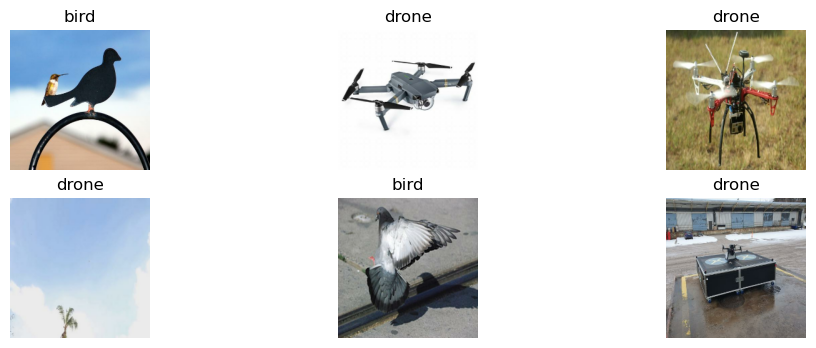

In [3]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(12, 4))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = int(labels[i].numpy())
        plt.title(class_names[label_idx])
        plt.axis("off")
    break


#### 4. (Optional) Visual Check After Normalization

Even though the numerical range has changed, the images should *look the same* when plotted.

Here I visualize a few normalized images from the training set to ensure that:

- Normalization did not corrupt the data.
- Labels still align with the expected classes.


In [4]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_norm = (
    train_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds_norm = (
    val_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_ds_norm = (
    test_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

train_ds_norm, val_ds_norm, test_ds_norm


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

Min pixel value: 0.0
Max pixel value: 1.0


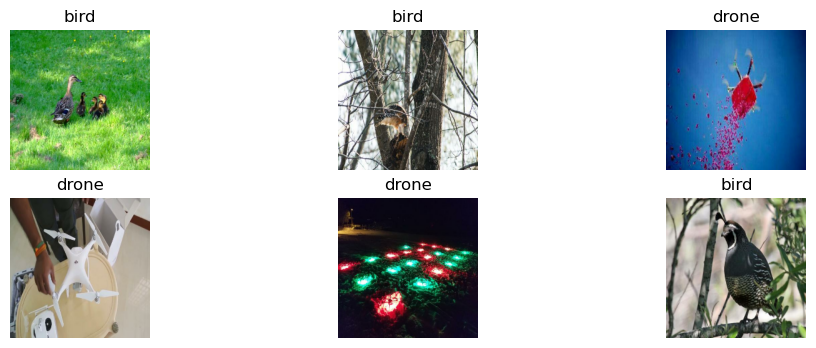

In [5]:
for images, labels in train_ds_norm.take(1):
    print("Min pixel value:", images.numpy().min())
    print("Max pixel value:", images.numpy().max())

    plt.figure(figsize=(12, 4))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = int(labels[i].numpy().item())
        plt.title(class_names[label_idx])
        plt.axis("off")
    break


#### 5. Reusable Loader Function (for `src/data_loader.py`)

To keep the training code clean, I wrap the entire pipeline into a helper function.

Later, I can move this function into `src/data_loader.py` and simply call:

```python
from src.data_loader import get_datasets
train_ds, val_ds, test_ds, class_names = get_datasets(...)


In [6]:


def get_tf_datasets(
    base_dir: str | Path = "../data/classification_dataset",
    img_size: tuple[int, int] = (224, 224),
    batch_size: int = 32
):
    base_dir = Path(base_dir)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir / "train",
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir / "valid",
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary"
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir / "test",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        label_mode="binary"
    )

    class_names = train_ds.class_names

    def normalize_img(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    train_ds = (
        train_ds
        .map(normalize_img, num_parallel_calls=AUTOTUNE)
        .shuffle(1000)
        .prefetch(AUTOTUNE)
    )

    val_ds = (
        val_ds
        .map(normalize_img, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    test_ds = (
        test_ds
        .map(normalize_img, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return train_ds, val_ds, test_ds, class_names

# quick smoke test
train_ds_norm, val_ds_norm, test_ds_norm, class_names = get_tf_datasets()
train_ds_norm, val_ds_norm, test_ds_norm, class_names


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 ['bird', 'drone'])

#### 6.  Summary

In this notebook I:

- Fixed the image size to **224 × 224** and batch size to **32**.
- Built TensorFlow `tf.data` pipelines for `train`, `valid`, and `test` splits.
- Normalized image pixel values from `[0, 255]` to `[0, 1]`.
- Added performance optimizations: shuffling (train), caching, and prefetching.
- Created a reusable `get_tf_datasets` function that will be used in training notebooks and can be moved to `src/data_loader.py`.

Next step (Day 3):  
➡ Define and train a **Custom CNN** using this data pipeline.
